# FB Stock Forecasting using Neural Networks

Downloaded from: https://ca.finance.yahoo.com/quote/FB/history?period1=1337313600&period2=1551502800&interval=1d&filter=history&frequency=1d

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [82]:
df = pd.read_csv('FB.csv')
df['Date'] = pd.to_datetime(df['Date'])
# df.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
df.drop(['Open','Adj Close'], axis=1, inplace=True)
df = df.set_index(['Date'], drop=True)
df.head(7)

,High,Low,Close,Volume
Date,,,,
2012-05-18,45.000000,38.000000,38.230000,573576400
2012-05-21,36.660000,33.000000,34.029999,168192700
2012-05-22,33.590000,30.940001,31.000000,101786600
2012-05-23,32.500000,31.360001,32.000000,73600000
2012-05-24,33.209999,31.770000,33.029999,50237200
2012-05-25,32.950001,31.110001,31.910000,37149800
2012-05-29,31.690001,28.650000,28.840000,78063400


### Over time
Wiggly!

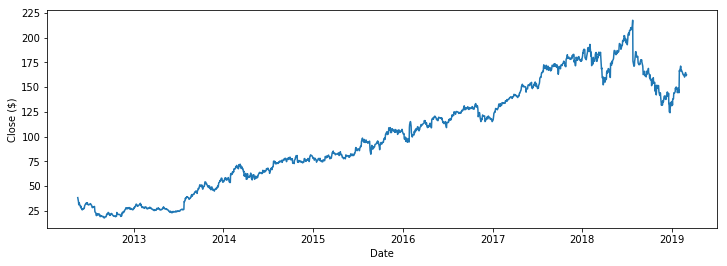

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(df.Close)
plt.ylabel('Close ($)')
plt.xlabel('Date')
plt.show()

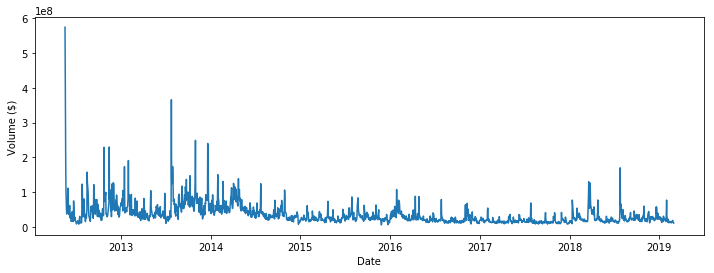

In [62]:
plt.figure(figsize=(12, 4))
plt.plot(df.Volume)
plt.ylabel('Volume ($)')
plt.xlabel('Date')
plt.show()

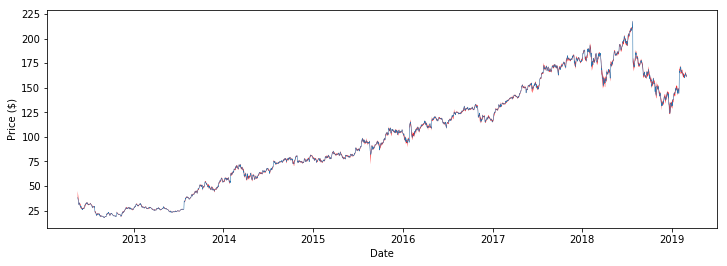

In [88]:
plt.figure(figsize=(12, 4))
plt.plot(df.Close,lw=0.5)
plt.fill_between(df.index, df.Low, df.High, facecolor='red', alpha=.9, label='Uncertainty')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.show()

Wow, the line width is pretty much the same size as the daily Low/High variation.

## Feauture Building
Will use the last 5 days of closing data as well. Let's use the `shift` pandas function to build these features

In [89]:
## Get the close from the last 5 days
for s in range(1,6):
    df['Close_{}_DayAgo'.format(s)] = df['Close'].shift(s)

for s in range(1,6):
    df['Volume_{}_DayAgo'.format(s)] = df['Volume'].shift(s)
    
for s in range(1,6):
    df['Low_{}_DayAgo'.format(s)] = df['Volume'].shift(s)

for s in range(1,6):
    df['High_{}_DayAgo'.format(s)] = df['Volume'].shift(s)
    
## Get rid of days for which we don't have the full history
X = df.dropna().drop(['Close','Volume','Low','High'], axis=1)
y = df.dropna()[['Close']]
df.head(7)

,High,Low,Close,Volume,Close_1_DayAgo,Close_2_DayAgo,Close_3_DayAgo,Close_4_DayAgo,Close_5_DayAgo,Volume_1_DayAgo,...,Low_1_DayAgo,Low_2_DayAgo,Low_3_DayAgo,Low_4_DayAgo,Low_5_DayAgo,High_1_DayAgo,High_2_DayAgo,High_3_DayAgo,High_4_DayAgo,High_5_DayAgo
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-18,45.000000,38.000000,38.230000,573576400,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21,36.660000,33.000000,34.029999,168192700,38.230000,NaN,NaN,NaN,NaN,573576400.0,...,573576400.0,NaN,NaN,NaN,NaN,573576400.0,NaN,NaN,NaN,NaN
2012-05-22,33.590000,30.940001,31.000000,101786600,34.029999,38.230000,NaN,NaN,NaN,168192700.0,...,168192700.0,573576400.0,NaN,NaN,NaN,168192700.0,573576400.0,NaN,NaN,NaN
2012-05-23,32.500000,31.360001,32.000000,73600000,31.000000,34.029999,38.230000,NaN,NaN,101786600.0,...,101786600.0,168192700.0,573576400.0,NaN,NaN,101786600.0,168192700.0,573576400.0,NaN,NaN
2012-05-24,33.209999,31.770000,33.029999,50237200,32.000000,31.000000,34.029999,38.230000,NaN,73600000.0,...,73600000.0,101786600.0,168192700.0,573576400.0,NaN,73600000.0,101786600.0,168192700.0,573576400.0,NaN
2012-05-25,32.950001,31.110001,31.910000,37149800,33.029999,32.000000,31.000000,34.029999,38.230000,50237200.0,...,50237200.0,73600000.0,101786600.0,168192700.0,573576400.0,50237200.0,73600000.0,101786600.0,168192700.0,573576400.0
2012-05-29,31.690001,28.650000,28.840000,78063400,31.910000,33.029999,32.000000,31.000000,34.029999,37149800.0,...,37149800.0,50237200.0,73600000.0,101786600.0,168192700.0,37149800.0,50237200.0,73600000.0,101786600.0,168192700.0


In [90]:
X.head(4)

,Close_1_DayAgo,Close_2_DayAgo,Close_3_DayAgo,Close_4_DayAgo,Close_5_DayAgo,Volume_1_DayAgo,Volume_2_DayAgo,Volume_3_DayAgo,Volume_4_DayAgo,Volume_5_DayAgo,Low_1_DayAgo,Low_2_DayAgo,Low_3_DayAgo,Low_4_DayAgo,Low_5_DayAgo,High_1_DayAgo,High_2_DayAgo,High_3_DayAgo,High_4_DayAgo,High_5_DayAgo
Date,,,,,,,,,,,,,,,,,,,,
2012-05-25,33.029999,32.000000,31.000000,34.029999,38.230000,50237200.0,73600000.0,101786600.0,168192700.0,573576400.0,50237200.0,73600000.0,101786600.0,168192700.0,573576400.0,50237200.0,73600000.0,101786600.0,168192700.0,573576400.0
2012-05-29,31.910000,33.029999,32.000000,31.000000,34.029999,37149800.0,50237200.0,73600000.0,101786600.0,168192700.0,37149800.0,50237200.0,73600000.0,101786600.0,168192700.0,37149800.0,50237200.0,73600000.0,101786600.0,168192700.0
2012-05-30,28.840000,31.910000,33.029999,32.000000,31.000000,78063400.0,37149800.0,50237200.0,73600000.0,101786600.0,78063400.0,37149800.0,50237200.0,73600000.0,101786600.0,78063400.0,37149800.0,50237200.0,73600000.0,101786600.0
2012-05-31,28.190001,28.840000,31.910000,33.029999,32.000000,57267900.0,78063400.0,37149800.0,50237200.0,73600000.0,57267900.0,78063400.0,37149800.0,50237200.0,73600000.0,57267900.0,78063400.0,37149800.0,50237200.0,73600000.0


In [91]:
y.head(4)

,Close
Date,
2012-05-25,31.910000
2012-05-29,28.840000
2012-05-30,28.190001
2012-05-31,29.600000


## Test and train split

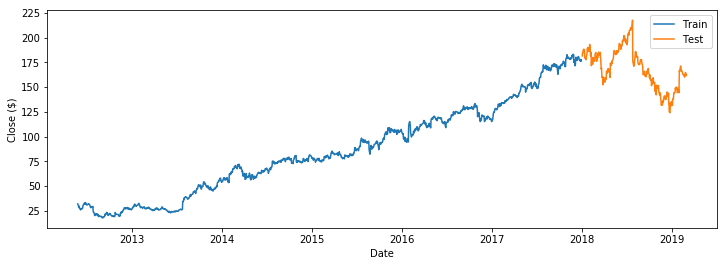

In [92]:
## Training data will be prior to Jan 1st 2018, will test on the rest
split_date = pd.Timestamp('2018-01-01')
X_train = X.query('Date < "2018-01-01"')
y_train = y.query('Date < "2018-01-01"')

X_test = X.query('Date >= "2018-01-01"')
y_test = y.query('Date >= "2018-01-01"')

plt.figure(figsize=(12, 4))
plt.plot(y_train.Close, label='Train')
plt.plot(y_test.Close, label='Test')
plt.ylabel('Close ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

## Feature Scaling
Simple (-1,1) scaling using `sklearn.MinMaxScaler`

In [93]:
scaler_X = MinMaxScaler(feature_range=(-1,1))
X_train_sc = scaler_X.fit_transform(X_train)
X_test_sc = scaler_X.transform(X_test)

## Need to scale `Close` separately in order to be able to invert the scale later
scaler_y = MinMaxScaler(feature_range=(-1,1))
y_train_sc = scaler_y.fit_transform(y_train)
y_test_sc = scaler_y.transform(y_test)

print(X_train_sc.shape,y_train.shape,X_test_sc.shape,y_test_sc.shape)

((1409, 20), (1409, 1), (292, 20), (292, 1))


In [94]:
X_train_sc

array([[-0.81488204, -0.82734422, -0.83944344, ..., -0.46669511,
        -0.09730526,  1.        ],
       [-0.82843315, -0.81488204, -0.82734422, ..., -0.62348559,
        -0.46669511, -0.42825404],
       [-0.86557774, -0.82843315, -0.81488204, ..., -0.75344324,
        -0.62348559, -0.66221702],
       ...,
       [ 0.91482161,  0.92946156,  0.93248636, ..., -0.96836222,
        -0.96691706, -0.96826464],
       [ 0.93454321,  0.91482161,  0.92946156, ..., -0.98568245,
        -0.96836222, -0.97904603],
       [ 0.93817301,  0.93454321,  0.91482161, ..., -0.98340012,
        -0.98568245, -0.97996136]])

In [95]:
X_train_sc[:,0]

array([-0.81488204, -0.82843315, -0.86557774, ...,  0.91482161,
        0.93454321,  0.93817301])

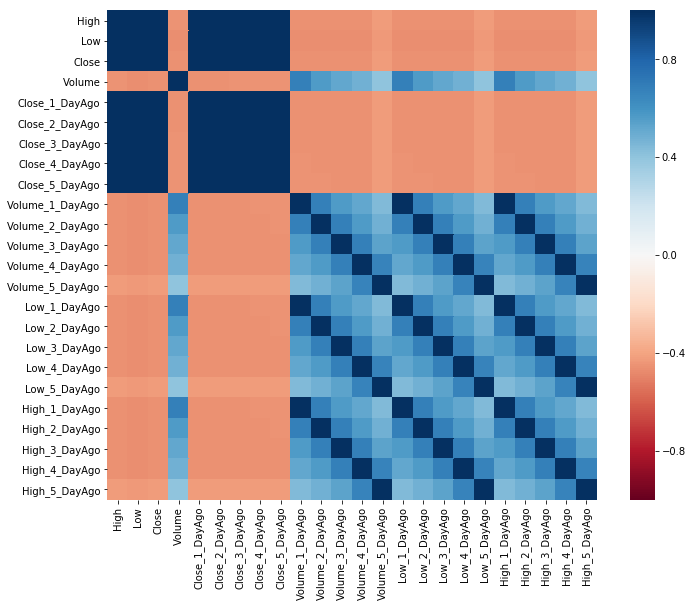

In [97]:
corrmat = df.dropna().corr()
f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmin=-1.0, vmax=1.0, square=True, annot=True, fmt='.3f', cmap="RdBu");
sns.heatmap(corrmat, vmin=-1.0, vmax=1.0, square=True, cmap="RdBu");

## Simple Neural Network
Will use the `Sequential` Keras model to build a simple 2-layer linear network. The first layer has 12 neurons with a `ReLu` activation function. It takes the (n-dimensional) info from the previous day as input. The second layer collects it all into a single neuron with the final ouput.

### Using only the close date from the previous day

In [98]:
nn_model_oneday = Sequential()
nn_model_oneday.add(Dense(12, input_dim=1, activation='relu'))
nn_model_oneday.add(Dense(1))
nn_model_oneday.compile(loss='mean_squared_error',optimizer='adam')
early_stop = EarlyStopping(monitor='loss',patience=2, verbose=1)
history_oneday = nn_model_oneday.fit(X_train_sc[:,0], y_train_sc, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0150
Epoch 2/100
1409/1409 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 3/100
1409/1409 [==============================] - 2s 1ms/step - loss: 7.9038e-04
Epoch 4/100
1409/1409 [==============================] - 2s 2ms/step - loss: 6.6346e-04
Epoch 5/100
1409/1409 [==============================] - 3s 2ms/step - loss: 6.0965e-04
Epoch 6/100
1409/1409 [==============================] - 2s 2ms/step - loss: 5.4605e-04
Epoch 7/100
1409/1409 [==============================] - 2s 1ms/step - loss: 4.8494e-04
Epoch 8/100
1409/1409 [==============================] - 3s 2ms/step - loss: 4.4635e-04
Epoch 9/100
1409/1409 [==============================] - 2s 2ms/step - loss: 4.2773e-04
Epoch 10/100
1409/1409 [==============================] - 2s 2ms/step - loss: 4.1761e-04
Epoch 11/100
1409/1409 [==============================] - 2s 2ms/step - loss: 4.1009e-04
Epoch 12/100
1409/1409 [==============

In [99]:
y_pred_train_nn_oneday = nn_model_oneday.predict(X_train_sc[:,3])
y_pred_test_nn_oneday = nn_model_oneday.predict(X_test_sc[:,3])
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_sc, y_pred_train_nn_oneday)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_sc, y_pred_test_nn_oneday)))

The R2 score on the Train set is:	0.985
The R2 score on the Test set is:	0.838


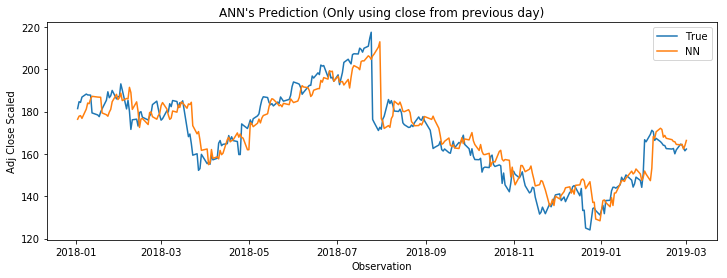

In [100]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index[:], scaler_y.inverse_transform(y_test_sc), label='True')
plt.plot(y_test.index[:], scaler_y.inverse_transform(y_pred_test_nn_oneday), label='NN')

plt.title("ANN's Prediction (Only using close from previous day)")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show()

### Using all the features (close dates from last five days)

In [107]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=20, activation='relu'))
# nn_model.add(Dense(12, activation='relu'))
# nn_model.add(Dense(6,activation='relu'))
# nn_model.add(Dense(6, activation='relu'))
# nn_model.add(Dense(3, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error',optimizer='adam')
early_stop = EarlyStopping(monitor='loss',patience=2, verbose=1)
history = nn_model.fit(X_train_sc, y_train_sc, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0142
Epoch 2/100
1409/1409 [==============================] - 5s 3ms/step - loss: 0.0065
Epoch 3/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0021
Epoch 4/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 5/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 6/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0017
Epoch 7/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 8/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 9/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 10/100
1409/1409 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 11/100
1409/1409 [==============================] - 5s 3ms/step - loss: 0.0014
Epoch 12/100
1409/1409 [==============================] - 4s 3ms/step - lo

In [105]:
y_pred_train_nn = nn_model.predict(X_train_sc)
y_pred_test_nn = nn_model.predict(X_test_sc)
print(len(X_train_sc), len(y_pred_train_nn), len(y_train_sc))
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_sc, y_pred_train_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_sc, y_pred_test_nn)))

(1409, 1409, 1409)
The R2 score on the Train set is:	0.706
The R2 score on the Test set is:	-0.078


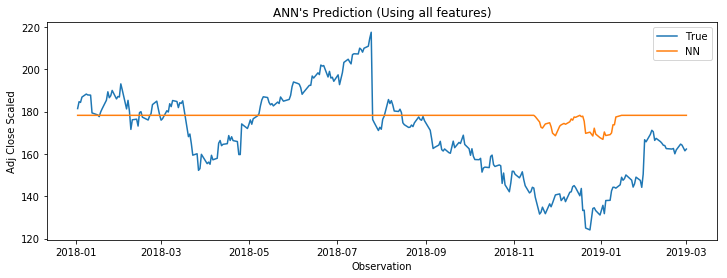

In [106]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index[:], scaler_y.inverse_transform(y_test_sc), label='True')
plt.plot(y_test.index[:], scaler_y.inverse_transform(y_pred_test_nn), label='NN')

## Just the last 100 days
# plt.plot(test.index[-100:],scaler_y.inverse_transform(y_test)[-100:], label='True')
# plt.plot(test.index[-100:],scaler_y.inverse_transform(y_pred_test_nn[-100:]), label='NN')

plt.title("ANN's Prediction (Using all features)")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show()

#### The $R^2$ score increases from 0.77 to 0.95 on the test set when using all the features!

## LSTM
Now let's try a Long-Short-Term Memory Recurrent Neural Network.

We need to convert our data into the three-dimensional format expected by the LSTM. The first dimensions is the number of rows in the dataset. 

In [43]:
X_train_sc_one = X_train_sc[:,0:1]
X_test_sc_one = X_test_sc[:,0:1]
X_train_lmse_one = X_train_sc_one.reshape(X_train_sc_one.shape[0], X_train_sc_one.shape[1], 1)
X_test_lmse_one = X_test_sc_one.reshape(X_test_sc_one.shape[0], X_test_sc_one.shape[1], 1)

In [44]:
lstm_model_one = Sequential()
lstm_model_one.add(LSTM(units=7, input_shape=(X_train_sc_one.shape[1],1), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model_one.add(Dense(1))
lstm_model_one.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model_one = lstm_model_one.fit(X_train_lmse_one, y_train_sc, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1409/1409 [==============================] - 8s 6ms/step - loss: 0.0793
Epoch 2/100
1409/1409 [==============================] - 5s 4ms/step - loss: 0.0312
Epoch 3/100
1409/1409 [==============================] - 6s 4ms/step - loss: 0.0033
Epoch 4/100
1409/1409 [==============================] - 6s 4ms/step - loss: 0.0015
Epoch 5/100
1409/1409 [==============================] - 6s 4ms/step - loss: 8.2972e-04
Epoch 6/100
1409/1409 [==============================] - 6s 4ms/step - loss: 4.1797e-04
Epoch 7/100
1409/1409 [==============================] - 6s 4ms/step - loss: 4.3574e-04
Epoch 8/100
1409/1409 [==============================] - 7s 5ms/step - loss: 5.4524e-04
Epoch 00008: early stopping


In [16]:
y_pred_train_lstm_one = lstm_model_one.predict(X_train_lmse_one)
y_pred_test_lstm_one = lstm_model_one.predict(X_test_lmse_one)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_sc, y_pred_train_lstm_one)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_sc, y_pred_test_lstm_one)))

The R2 score on the Train set is:	0.991
The R2 score on the Test set is:	0.932


### Using more than the one features makes the algorithm crash :'(
Using all features crashes

In [17]:
X_train_sc_two = X_train_sc[:,3:5]
X_test_sc_two = X_test_sc[:,3:5]
X_train_lmse = X_train_sc_two.reshape(X_train_sc_two.shape[0], X_train_sc_two.shape[1], 1)
X_test_lmse = X_test_sc_two.reshape(X_test_sc_two.shape[0], X_test_sc_two.shape[1], 1)

In [18]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=7, input_shape=(X_train_lmse.shape[1],1), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train_sc, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1409/1409 [==============================] - 9s 6ms/step - loss: 0.0463
Epoch 2/100
1409/1409 [==============================] - 7s 5ms/step - loss: 0.0027
Epoch 3/100
1409/1409 [==============================] - 9s 6ms/step - loss: 7.5293e-04
Epoch 4/100
1409/1409 [==============================] - 7s 5ms/step - loss: 7.1545e-04
Epoch 5/100
1409/1409 [==============================] - 8s 6ms/step - loss: 7.1447e-04
Epoch 6/100
1409/1409 [==============================] - 8s 6ms/step - loss: 6.9005e-04
Epoch 7/100
1409/1409 [==============================] - 8s 5ms/step - loss: 6.5275e-04
Epoch 8/100
1409/1409 [==============================] - 8s 6ms/step - loss: 6.2879e-04
Epoch 9/100
1409/1409 [==============================] - 9s 6ms/step - loss: 5.9547e-04
Epoch 10/100
1409/1409 [==============================] - 9s 6ms/step - loss: 5.7647e-04
Epoch 11/100
1409/1409 [==============================] - 10s 7ms/step - loss: 5.6477e-04
Epoch 12/100
1409/1409 [=============